In [1]:
# Imports and scripts
#import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
import ray
ray.init(ignore_reinit_error=True)
%run ../script/GatherData.py

2021-03-24 23:46:30,870	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


To request implementation, send an email to feature_requests@modin.org.


Text(0.5, 1.0, 'Shows the number of files for every label, from JabRef')

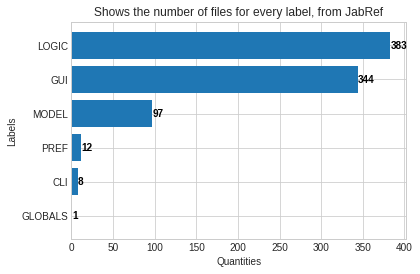

In [2]:
dataset_df = pd.read_csv(str(RP.getRawDataSet()))
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Quantities')
plt.ylabel('Labels')
plt.title('Shows the number of files for every label, from JabRef')

In [3]:
test_file = '../Data/test.csv'
"""
settings matrix
"""
# maxent 
s0 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'stem'],
    ['pac', 'tow', 'jk'],
    ]

s1 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'stem'],
    ['pac',  'tow', 'jk'],
    ['com', 'tow', 'jk', 'scw', 'lc', 'sw'],
]

# Interestting results
s2 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pac', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pm', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['com', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['c', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
]

s3 = [
    ['pac', 'tow', 'jk'],
    ['lib', 'tow', 'scw', 'jk', 'lc', 'stem'],
    ['pm', 'tow', 'scw', 'jk', 'lc', 'sw'],
]
s4 = [
    ['pac', 'tow', 'jk',],
    ['lib', 'tow', 'scw', 'jk', 'lc', 'stem'],
    ['c', 'tow', 'scw', 'jk', 'lc'],
    ['pm', 'tow', 'scw', 'jk', 'lc', 'sw', 'stem'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
]
s5 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pac', 'tow', 'jk'],
    ['pm', 'tow', 'jk', 'scw','lc', 'sw'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['com', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['c', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
]
s6 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pac', 'tow', 'jk'],
    ['pm', 'tow', 'jk', 'scw','lc', 'sw'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw'],
    ['com', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['c', 'tow', 'jk', 'scw','lc', 'sw'],
]

settings_matrix = [s0, s1, s2, s3, s4 ,s5, s6]

In [10]:
def make_datafram_row(metrics, setting: list, setting_id: int ):
    report = metrics.get_classification_report()
    quantity_table = metrics.quantity_table()
    setting_id = 's' + str(setting_id)
    row = {
        'classifier': [metrics.name],
        'setting_id': [setting_id],
        'settings': [setting],
        'accuracy': [report['accuracy']],
        'w_avg_precision': [report['weighted avg']['precision']],
        'w_avg_recall': [report['weighted avg']['recall']],
        'train_size': [quantity_table['Train'].sum()], 
        'test_size': [quantity_table['Test'].sum()], 
        'report_table': [metrics.total_report_table()] 
    }
    df_row = pd.DataFrame(row)
    return df_row

In [11]:
df_columns = [
    'classifier',
    'setting_id',
    'settings', 
    'accuracy', 
    'w_avg_precision', 
    'w_avg_recall', 
    'train_size', 
    'test_size', 
    'report_table' 
]
main_table = pd.DataFrame(columns=df_columns)
test_size=0.9
fold_quantity = 10

for index, setting in enumerate(settings_matrix):
    Prep.preprocess_settings(setting, test_file)
    test_df = pd.read_csv(test_file)

    # Remove GLOBALS and CLI from the dataset
    df_sliced = Eva.filter_unwanted_labels(test_df, 'Label', ['GLOBALS', 'CLI'])

    feature_representation = CountVectorizer()
    confusion_list = []

    # Train and gather evaluation metrics
    evaluate = Eva.Evaluation(df_sliced, feature_representation, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    df_row = make_datafram_row(metrics_max_ent, setting, index)
    main_table = main_table.append(df_row)

    df_row = make_datafram_row(metrics_svm, setting, index)
    main_table = main_table.append(df_row)
    
    df_row = make_datafram_row(metrics_naive, setting, index)
    main_table = main_table.append(df_row)

main_table = main_table.reset_index(drop=True)
main_table.to_csv('../Data/analysis.csv')

836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


836
836


In [12]:
main_table

,classifier,setting_id,settings,accuracy,w_avg_precision,w_avg_recall,train_size,test_size,report_table
0,MaxEnt,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.922975,0.938585,0.922975,83,753,GUI LOGIC MODEL ...
1,SVM,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.941567,0.937786,0.941567,83,753,GUI LOGIC MODEL ...
2,Naive-Bayes,s0,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.917663,0.917277,0.917663,83,753,GUI LOGIC MODEL ...
3,MaxEnt,s1,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]...",0.865870,0.865320,0.865870,83,753,GUI LOGIC MODEL ...
4,SVM,s1,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]...",0.873838,0.873690,0.873838,83,753,GUI LOGIC MODEL ...
5,Naive-Bayes,s1,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]...",0.806109,0.804174,0.806109,83,753,GUI LOGIC MODEL ...
6,MaxEnt,s2,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.788845,0.796223,0.788845,83,753,GUI LOGIC MODEL ...
7,SVM,s2,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.767596,0.774274,0.767596,83,753,GUI LOGIC MODEL ...
8,Naive-Bayes,s2,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.814077,0.804238,0.814077,83,753,GUI LOGIC MODEL ...
9,MaxEnt,s3,"[[pac, tow, jk], [lib, tow, scw, jk, lc, stem]...",0.863214,0.880546,0.863214,83,753,GUI LOGIC MODEL ...


2021-03-25 00:08:16,685	ERROR worker.py:980 -- Possible unhandled error from worker: ray::deploy_ray_func() (pid=814548, ip=10.8.8.17)
  File "python/ray/_raylet.pyx", line 463, in ray._raylet.execute_task
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 114, in deploy_ray_func
    result = func(*args)
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/base/frame/axis_partition.py", line 294, in deploy_axis_func
    if sum(lengths) != len(result.columns):
AttributeError: 'int' object has no attribute 'columns'
2021-03-25 00:08:17,686	ERROR worker.py:980 -- Possible unhandled error from worker: ray::deploy_ray_func() (pid=814527, ip=10.8.8.17)
  File "python/ray/_raylet.pyx", line 463, in ray._raylet.execute_task
  File "/home/alex/dotfiles/python_venvs/exjobb_labEnv/lib/python3.8/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition